In [1]:
import cv2

In [2]:
cv2.__version__

'4.5.5'

In [3]:
assert cv2.__version__[0] >= '3', 'The fisheye module requires opencv version >= 3.0.0'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
%matplotlib inline

In [5]:
CHECKERBOARD = (6,9)

In [6]:
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

In [7]:
objp.shape

(1, 54, 3)

In [8]:
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

In [9]:
images = sorted(glob.glob('data/20220706_GPFR2882_front/*.jpeg'))
print(len(images))

39


In [10]:
for fname in tqdm(images):
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)

100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


In [11]:
N_OK = len(objpoints)
print(N_OK)

38


In [12]:
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

In [13]:
np.shape(rvecs)

(38, 1, 1, 3)

In [14]:
#rms, _, _, _, _ = \
retval, K, D, rvecs, tvecs = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

In [15]:
print("Found " + str(N_OK) + " valid images for calibration")

Found 38 valid images for calibration


In [16]:
print("DIM=" + str(_img_shape[::-1]))
# print("K=np.array(" + str(K.tolist()) + ")")
# print("D=np.array(" + str(D.tolist()) + ")")

DIM=(2704, 2624)


In [17]:
K

array([[9.45459598e+02, 0.00000000e+00, 1.35138128e+03],
       [0.00000000e+00, 9.49523029e+02, 1.31475810e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [18]:
D

array([[-0.0513526 ],
       [-0.00423388],
       [ 0.00087245],
       [-0.00034975]])

# Undistort images

In [19]:
DIM= _img_shape[::-1]

In [20]:
def undistort(img_path, K, D, DIM):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img
#     cv2.imshow("undistorted", undistorted_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [21]:
# fname1 = images[2]
# img = cv2.imread(fname1)
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# plt.figure(dpi=150)
# plt.axis('off')
# plt.imshow(gray, cmap='gray')

In [22]:
DIM

(2704, 2624)

In [23]:
fname1 = images[2]
print(fname1)

data/20220706_GPFR2882_front/GPFR2882_11.jpeg


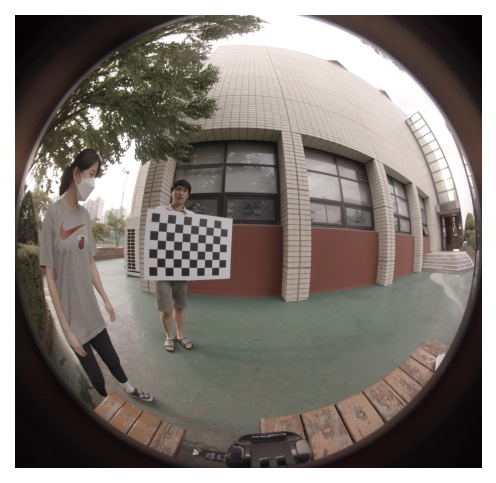

In [24]:
img = cv2.imread(fname1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(dpi=150)
_ = plt.axis('off')
plt.imshow(img)

In [25]:
undistorted_img  =undistort(fname1, K, D, DIM)
undistorted_img = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB)

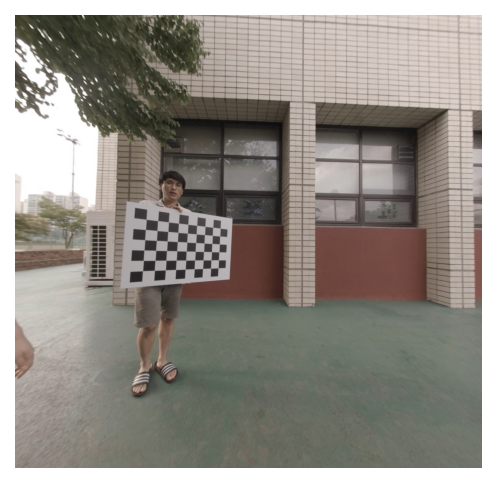

In [26]:
plt.figure(dpi=150)
plt.axis('off')
plt.imshow(undistorted_img, cmap='gray')

OpenCV fisheye calibration cuts too much of the image. 
https://stackoverflow.com/a/44009548

In [27]:
## Adjusting the K

In [28]:
nk = K.copy()
nk[0,0]=K[0,0]/1.5
nk[1,1]=K[1,1]/1.5
# Just by scaling the matrix coefficients!

In [37]:
K

array([[9.45459598e+02, 0.00000000e+00, 1.35138128e+03],
       [0.00000000e+00, 9.49523029e+02, 1.31475810e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [29]:
nk

array([[6.30306399e+02, 0.00000000e+00, 1.35138128e+03],
       [0.00000000e+00, 6.33015353e+02, 1.31475810e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [30]:
#img = cv2.imread(img_path)
dim1 = img.shape[:2][::-1]
print(dim1)

(2704, 2624)


In [31]:
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), nk, dim1, cv2.CV_16SC2)  # Pass k in 1st parameter, nk in 4th parameter
nemImg = cv2.remap( img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

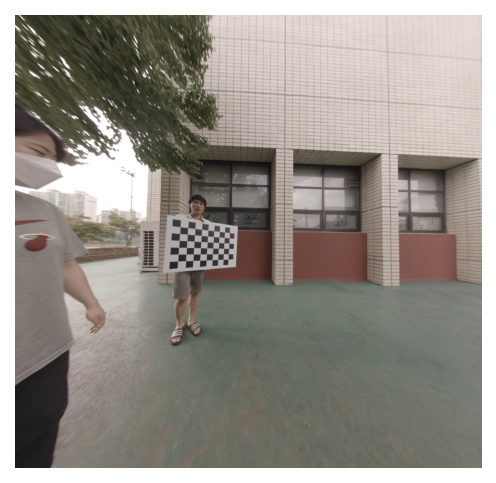

In [32]:
plt.figure(dpi=150)
plt.axis('off')
plt.imshow(nemImg)

# References

https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0